<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten
#save_model_path = '/content/drive/MyDrive/Visual reg' # Mads

Mounted at /content/drive


In [2]:
!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Cloning into 'DLVR'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 465 (delta 73), reused 68 (delta 68), pack-reused 384 (from 1)
Receiving objects: 100% (465/465), 55.11 MiB | 45.96 MiB/s, done.
Resolving deltas: 100% (259/259), done.
/content/DLVR


In [3]:
from utils.utkface import load_utkface
load_utkface()

from utils.utkface import preprocess_utkface
df_utkface, df_utkface_raw = preprocess_utkface()

df = df_utkface_raw[['age_raw','gender_code','race_code','file']]
df = df[df['age_raw']<=100]
df.rename(columns={'age_raw': 'age_code'}, inplace=True)

from utils.preprocessing import create_lists
images, ages, races, genders = create_lists(df)
print(f"Loaded {len(images)} images.")

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

# Preprocess images
from keras.applications.resnet_v2 import preprocess_input
images_preprocessed = preprocess_input(images)

# Split into train (80%) and temp (20%)
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(images_preprocessed, ages, races, genders, test_size=0.20, random_state=42, stratify=ages)

# Split temp into validation (75% of temp, which is 15% of original data) and test (25% of temp, which is 5% of original data)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.25, random_state=42)


print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz
Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg
Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


Processing images:   0%|          | 0/24079 [00:00<?, ?it/s]

Loaded 24079 images.
Number of age classes: 97
Number of gender classes: 2
Number of ethnicity classes: 5
Training set: (19263, 224, 224, 3), Training labels: (19263,)
Age validation set: (3612, 224, 224, 3), Age validation labels: (3612,)
Age test set: (1204, 224, 224, 3), Age test labels: (1204,)
Race validation labels: (3612,)
Race test labels: (1204,)
Gender validation labels: (3612,)
Gender test labels: (1204,)


# Multitask experiment

Compare to the model from Regression_approach.ipynb under the title "Baseline middel learning rate"

In [4]:
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np
input_shape = images[0].shape

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
conv_base.trainable = False

######### ENCODER #########
inputs = keras.Input(input_shape)
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

######### AGE #########
age = layers.Dense(512, activation='relu')(x)
age = layers.BatchNormalization()(age)
age = layers.Dropout(0.3)(age)

age = layers.Dense(256, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dropout(0.2)(age)

age = layers.Dense(128, activation='relu')(age)
age = layers.BatchNormalization()(age)

age = layers.Dense(64, activation='relu')(age)
age = layers.Dense(1, activation='linear', name='age_output')(age)

######### GENDER #########
gender = layers.Dense(256, activation='relu')(x)
gender = layers.BatchNormalization()(gender)
gender = layers.Dropout(0.2)(gender)

gender = layers.Dense(128, activation='relu')(gender)
gender = layers.Dense(num_classes_gender, activation="softmax", name='gender_output')(gender)


######### MODEL #########
multitask_model = keras.Model(inputs=inputs, outputs=[age, gender])
multitask_model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50v2 (Functional)     (None, 7, 7, 2048)           2356480   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 global_average_pooling2d (  (None, 2048)                 0         ['resnet50v2[0][0]']          
 GlobalAveragePooling2D)                                                                          
                             

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

multitask_model.compile(
    optimizer=optimizer,
    loss={
        "age_output": "mean_squared_error",
        "gender_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "age_output": ["mae"],
        "gender_output": ["accuracy"]
    },
    loss_weights={
        "age_output": 0.6,
        "gender_output": 0.4
    }
)

from tensorflow.keras.callbacks import ModelCheckpoint
model_name = 'resnet50v2_model_multitask.keras'
multitask_checkpoint = ModelCheckpoint(
    save_model_path + model_name,
    monitor='val_age_output_mae',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [8]:
# Train the model
multitask_history = multitask_model.fit(
    X_train,
    [y_train_age, y_train_gender],
    epochs=40,
    batch_size=64,
    validation_data=(X_val, [y_val_age, y_val_gender]),
    callbacks=[multitask_checkpoint]
)

Epoch 1/40
301/301 [==============================] - ETA: 0s - loss: 535.5632 - age_output_loss: 892.3753 - gender_output_loss: 0.3446 - age_output_mae: 24.9478 - gender_output_accuracy: 0.8530
Epoch 1: val_age_output_mae improved from -inf to 16.50083, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/resnet50v2_model_multitask.keras
301/301 [==============================] - 303s 1s/step - loss: 535.5632 - age_output_loss: 892.3753 - gender_output_loss: 0.3446 - age_output_mae: 24.9478 - gender_output_accuracy: 0.8530 - val_loss: 264.4095 - val_age_output_loss: 440.4688 - val_gender_output_loss: 0.3207 - val_age_output_mae: 16.5008 - val_gender_output_accuracy: 0.8674
Epoch 2/40
301/301 [==============================] - ETA: 0s - loss: 212.1381 - age_output_loss: 353.3781 - gender_output_loss: 0.2780 - age_output_mae: 14.5943 - gender_output_accuracy: 0.8829
Epoch 2: val_age_output_mae did not improve from 16.50083
301/301 [============================

########## Age ##########
Best Training MAE: 4.0198
Best Validation MAE: 7.3318
Best Training Loss: 28.5359
Best Validation Loss: 115.1633


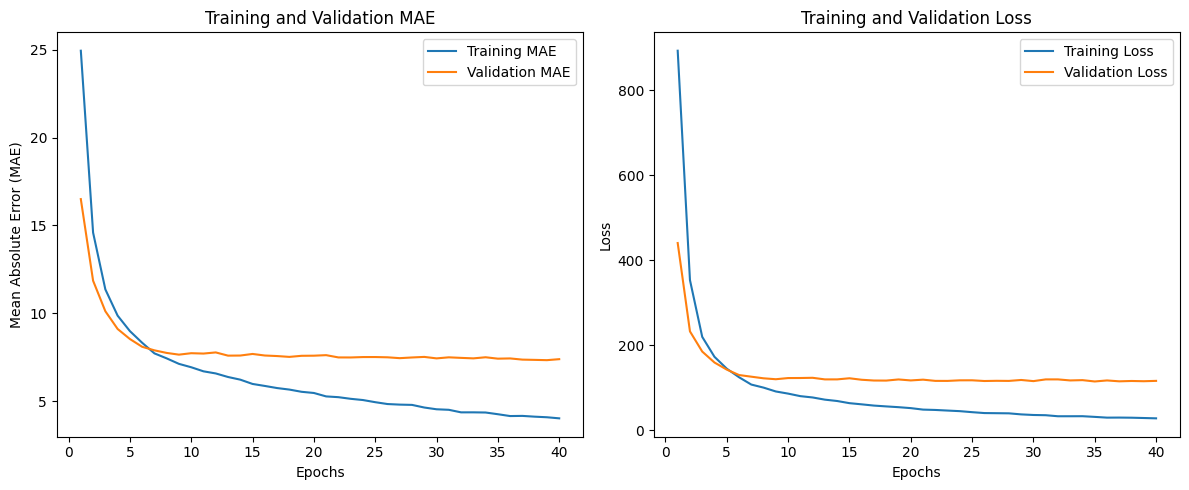


########## Gender ##########
Best Training Accuracy: 0.9949
Best Validation Accuracy: 0.8981
Best Training Loss: 0.0163
Best Validation Loss: 0.2768


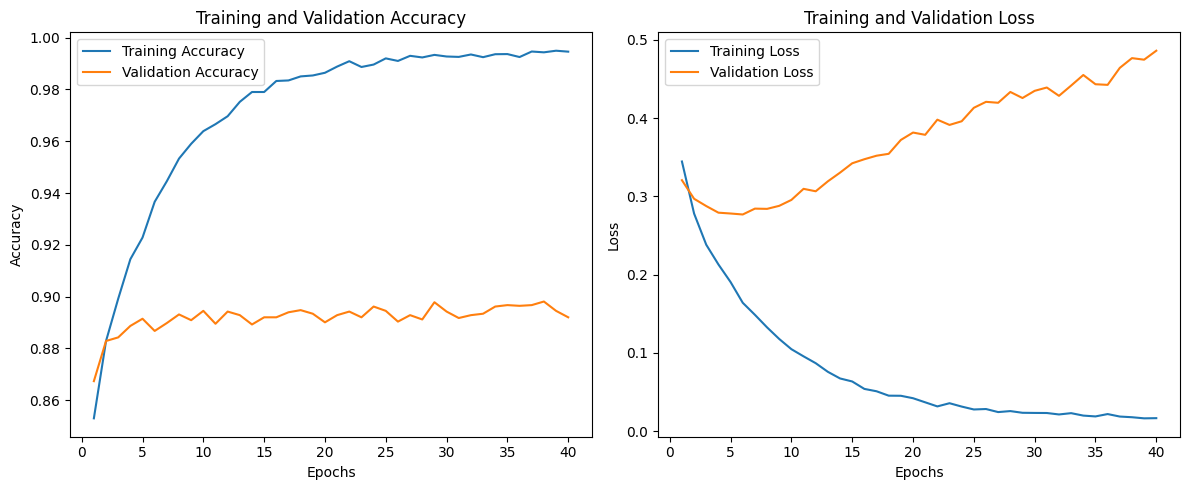

In [9]:
from utils.preprocessing import evaluate_and_plot_regression
from utils.preprocessing import evaluate_and_plot_classifier

# Evaluate and plot the model
print("########## Age ##########")
evaluate_and_plot_regression(multitask_history, 'age_output_mae', 'val_age_output_mae', 'age_output_loss', 'val_age_output_loss')
print("\n########## Gender ##########")
evaluate_and_plot_classifier(multitask_history, 'gender_output_accuracy', 'val_gender_output_accuracy', 'gender_output_loss', 'val_gender_output_loss')